## *Energy Onshore* 

##### *Libraries, Visualisation Functions & Tools*

In [6]:
from auto_tqdm import tqdm
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from IPython.display import Image

# Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")
# import matplotlib
# matplotlib.use('Agg')

# Coordinates
# Moray East (offshore)
lat_me = 58.167
lon_me = -2.699
# Markbygden (onshore)
lat_mb = 65.417
lon_mb = 20.667


# Plot examples
def plot_map(
    data,
    xmin,
    xmax,
    colormap,
    label,
    delta=12,
    region="eur",
    type="pcolormesh",
    extend="neither",
):
    import matplotlib.ticker as ticker

    data_crs = ccrs.PlateCarree()  # Projection.
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
    fig.subplots_adjust(bottom=0.14, top=0.90, left=0.05, right=0.95)
    nrow = 1
    ncol = 1
    outer = gs.GridSpec(nrow, ncol, wspace=0.01, hspace=0.02)

    var = data.values
    lon = data.lon.values
    lat = data.lat.values

    fsize = 17
    for i in range(nrow * ncol):
        ax = plt.subplot(outer[i], projection=data_crs)
        if region == "eur":
            ax.set_extent([-25.0, 45.0, 27.0, 72.0], crs=data_crs)
            # ax.add_geometries(reader.geometries(),ccrs.PlateCarree(),facecolor='darkgrey',edgecolor='darkgrey',alpha=0.4)
        elif region == "iber":
            ax.set_extent([-10.0, 5.0, 35.0, 45.0], crs=data_crs)
            # ax.add_geometries(reader.geometries(),ccrs.PlateCarree(),facecolor='darkgrey',edgecolor='darkgrey',alpha=0.5)
        ax.coastlines(resolution="10m")  # Draws the coastline.
        ax.add_feature(cfeature.LAKES, edgecolor="black")  # Adds lakes.
        ax.add_feature(cfeature.RIVERS, alpha=0.5)  # Adds rivers.
        # ax.add_feature(cfeature.BORDERS)

        gl = ax.gridlines(
            draw_labels=True, linestyle="dashed", alpha=0.25
        )  # Draws meridians and parallels.
        gl.xlabels_top = False
        gl.ylabels_right = False

        vmin, vmax = xmin, xmax
        delta = delta
        norm = mpc.PowerNorm(gamma=1, vmin=vmin, vmax=vmax)
        cmap = plt.cm.get_cmap(colormap)
        cmap.set_bad("lightblue", alpha=1.0)
        # cmap.set_under('white',alpha=1.)
        ax.add_feature(cfeature.OCEAN)

        lon2d, lat2d = np.meshgrid(lon, lat)
        if type == "pcolormesh":
            cs = ax.pcolormesh(
                lon2d, lat2d, var, norm=norm, transform=ccrs.PlateCarree(), cmap=cmap
            )
            cl = ax.contour(
                lon2d,
                lat2d,
                var,
                [0],
                colors="black",
                linestyles="dashed",
                linewidths=1.0,
                transform=ccrs.PlateCarree(),
                alpha=0.7,
            )

        elif type == "contourf":
            clevs = np.linspace(vmin, vmax, 256)
            cs = ax.contourf(
                lon2d,
                lat2d,
                var,
                levels=clevs,
                norm=norm,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend=extend,
            )
            cl = ax.contour(
                lon2d,
                lat2d,
                var,
                [0],
                colors="black",
                linestyles="dashed",
                linewidths=1.0,
                transform=ccrs.PlateCarree(),
                alpha=0.7,
            )

        size = 40
        fcolor = "black"

        cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.01])
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", extend=extend)
        cbar.set_label(label, rotation=0, fontsize=fsize)

        cbar.ax.tick_params(labelsize=fsize)
        tick_locator = ticker.MaxNLocator(nbins=delta / 2)  # set the number of ticks
        cbar.locator = tick_locator
        cbar.update_ticks()


# Plot the time series
def plot_time_series(
    data, xlabel, ylabel, labels, ymin, ymax, start, end, color, hline=None
):
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plotting the data directly using ax.plot for better practice
    for i in range(len(data)):
        ax.plot(data[i].time, data[i], label=labels[i], color=color)

    # Setting the x-axis tick labels
    xtick_labels = pd.date_range(start=start, end=end, freq="2D")[:-1]
    ax.set_xticks(xtick_labels.values)
    # Set xtick labels as month-day
    ax.set_xticklabels(xtick_labels.strftime("%m-%d"), rotation=30)

    # Setting x-axis limits based on input parameters
    ax.set_xlim([data[0].time.values[0], data[0].time.values[-1]])

    # Setting the y-axis limits
    ax.set_ylim([ymin, ymax])

    # Setting labels with specified font size
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Adding grid to the plot
    ax.grid(True)

    # Displaying the legend with an increased font size
    ax.legend(fontsize=15, loc="upper left")

    # Add dashed horizontal line if specified
    if hline is not None:
        ax.axhline(hline, color="black", linestyle="--")
    else:
        pass

    # Show the plot
    plt.show()


def plot_time_series1(data, xlabel, ylabel, labels, ymin, ymax, start, end, hline=None):
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plotting the data directly using ax.plot for better practice
    for i in range(len(data)):
        ax.plot(data[i].time, data[i], label=labels[i])

    # Setting the x-axis tick labels
    xtick_labels = pd.date_range(start=start, end=end, freq="2D")[:-1]
    ax.set_xticks(xtick_labels.values)
    # Set xtick labels as month-day
    ax.set_xticklabels(xtick_labels.strftime("%m-%d"), rotation=30)

    # Setting x-axis limits based on input parameters
    ax.set_xlim([data[0].time.values[0], data[0].time.values[-1]])

    # Setting the y-axis limits
    ax.set_ylim([ymin, ymax])

    # Setting labels with specified font size
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Adding grid to the plot
    ax.grid(True)

    # Displaying the legend with an increased font size
    ax.legend(fontsize=15, loc="upper left")

    # Add dashed horizontal line if specified
    if hline is not None:
        ax.axhline(hline, color="black", linestyle="--")
    else:
        pass

    # Show the plot
    plt.show()


# Global Wind Atlas color scale
from matplotlib.colors import LinearSegmentedColormap

# Define the RGB values for the color scale.
colors = [
    (153, 51, 102),
    (165, 47, 90),
    (176, 43, 77),
    (188, 39, 65),
    (199, 35, 52),
    (211, 31, 40),
    (226, 63, 40),
    (232, 78, 41),
    (238, 92, 41),
    (245, 106, 41),
    (246, 137, 53),
    (247, 160, 63),
    (248, 184, 73),
    (249, 208, 82),
    (250, 232, 92),
    (212, 221, 87),
    (178, 211, 83),
    (145, 202, 79),
    (111, 192, 75),
    (73, 181, 70),
    (73, 173, 99),
    (73, 165, 124),
    (72, 158, 148),
    (72, 150, 173),
    (72, 142, 202),
    (90, 158, 212),
    (106, 173, 220),
    (123, 187, 229),
    (141, 204, 238),
    (178, 226, 249),
    (197, 233, 250),
]

normalized_colors = np.array(colors) / 255.0

# Create a custom colormap with these colors
cmap = LinearSegmentedColormap.from_list("GWA", normalized_colors)

cmap = cmap.reversed()


def prepare_data(data):
    """
    Prepare data for the heatmap. The function takes a 1D array and converts it into a 2D array of shape (12, 31).
    Missing values are filled with np.nan.
    """
    assert len(data) <= 366, "Data length cannot exceed 366"

    # Create an empty 2D array filled with np.nan
    prepared_data = np.full((11, 31), np.nan)

    # Calculate month lengths for a non-leap year
    month_lengths = [28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    idx = 0
    for month in range(11):
        for day in range(month_lengths[month]):
            if idx < len(data):
                prepared_data[month][day] = data[idx]
                idx += 1

    return prepared_data


def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.01, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=15)
    cbar.ax.tick_params(labelsize="large")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(labels=col_labels)
    ax.set_yticklabels(labels=row_labels)

    ax.tick_params(axis="x", labelsize="large")
    ax.tick_params(axis="y", labelsize="large")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw,
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """
    import matplotlib.ticker

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


# Time period
tvec = np.arange("1990-01", "2000-01", dtype="datetime64[M]")
x = [np.datetime_as_string(t, unit="M").replace("-", "") for t in tvec]

# Data paths
path = "/scratch/b/b382091/climatedt/europe/"
path_output = "/scratch/b/b382091/climatedt/europe/indicators/energy/"
path_clim = "/scratch/b/b382091/climatedt/clims/"
path_urb = "./shapefile/"
# reader = shapereader.Reader(path_urb + "ne_10m_urban_areas.shp")

# Variables
variables = ["tas", "u100", "v100"]
variables_dt = ["2t", "u", "v"]
indicators = []

# Load the mask for Europe
path_mask = "./"
ds_mask = xr.open_dataset(path_mask + "country_mask_europe_10km.nc")
ds_mask.close()

# Extract the mask
mask_eur = ds_mask["mask"]
mask_codes = list(mask_eur.attrs["flag_meanings"].split(" "))
mask_flags = list(mask_eur.attrs["flag_values"])

# Select the country
# country1 = 'E'
# idx1 = mask_codes.index(country1)
# mask_idx1 = mask_flags[idx1]
# country2 = 'P'
# idx2 = mask_codes.index(country2)
# mask_idx2 = mask_flags[idx2]

# Extract the country mask for the given code
# country_mask = mask.where((mask == mask_idx1) | (mask == mask_idx2))

# Load the mask for Iberia
path_mask = "./"
ds_mask = xr.open_dataset(path_mask + "country_mask_iberia_10km.nc")
ds_mask.close()

# Extract the mask
mask = ds_mask["mask"]
mask_codes = list(mask.attrs["flag_meanings"].split(" "))
mask_flags = list(mask.attrs["flag_values"])

# Select the country
country1 = "E"
idx1 = mask_codes.index(country1)
mask_idx1 = mask_flags[idx1]
country2 = "P"
idx2 = mask_codes.index(country2)
mask_idx2 = mask_flags[idx2]

# Extract the country mask for the given code
mask_iber = mask.where((mask == mask_idx1) | (mask == mask_idx2))

### *Wind*

*wind.py* contains a comprehensive set of wind energy indicators:

- **Wind Speed Anomalies** \
    Wind anomalies compared to a 30-year baseline reference period.
- **Wind Power Density (WPD)** \
    Amount of energy available in wind at a given location.
- **Capacity Factor (CF)** \
    Ratio of actual energy produced by a wind turbine compared to its maximum theoretical output.
- **Capacity Factor Histogram** \
    Histogram of capacity factors over a 2D grid.
- **Capacity Factor Histogram (1D)** \
    Histogram of capacity factors at a given location.
- **Wind Speed Histogram** \
    Histogram of wind speed over a 2D grid.
- **Wind Speed Histogram (1D)** \
    Histogram of wind speed at a given location.
- **Annual Energy Production (AEP)** \
    Energy produced by a wind turbine / wind farm over a year.
- **High Wind Events** \
    Number of times wind speed exceeds a given threshold.
- **Low Wind Events** \
    Number of times wind speed is below a given threshold.
- **Cooling Degree Days (CDD)** \
    Weather-based index designed to describe the energy requirements of buildings in terms of cooling.
- **Heating Degree Days (HDD)** \
    Weather-based index designed to describe the energy requirements of buildings in terms of heating.

A limited set of solar indicators, *solar.py*, has also been included in the package:

- **Solar Capacity Factor (daily)** \
    Capacity factor of a PV solar panel at daily scale.
- **Annual Energy Production (daily)** \
    Annual energy production of a PV solar panel at daily scale.

#### *Validation*

![title](ws100_monthly_validation_1990_1999_europe.png)

![title](ws10_monthly_validation_1990_1999_europe.png)

In [16]:
# Importing support functions from the package.
from energy_onshore.core import select_region
from energy_onshore.core import select_point
from energy_onshore.core import wind_speed

In [17]:
# You can get information on the purpose, input and output parameters of each function.
help(wind_speed)

Help on function wind_speed in module energy_onshore.core:

wind_speed(u, v)
    Compute wind speed magnitude from u and v components.
    
    Input
    -------
    u: xarray.DataArray ; (time,lat,lon)
        U-component of wind.
    v: xarray.DataArray ; (time,lat,lon)
        V-component of wind.
    
    Output
    -------
    ws: xarray.DataArray ; (time,lat,lon)
        Wind speed magnitude.



In [15]:
# When running inside the streaming workflow the data would be retrieved and interpolated by the GSV interface.
# Selecting the period of interest, for example: DJF 1990-1991
var = 1
year = "1990"
months = ["12"]
t_sub = [year + m for m in months]
filenames = [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]
year = "1991"
months = ["01", "02"]
t_sub = [year + m for m in months]
filenames = filenames + [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]

# Loading the wind data
ds_u100 = xr.open_mfdataset(filenames, concat_dim="time", combine="nested")
ds_u100.close()

var = 2
year = "1990"
months = ["12"]
t_sub = [year + m for m in months]
filenames = [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]
year = "1991"
months = ["01", "02"]
t_sub = [year + m for m in months]
filenames = filenames + [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]

# Loading the wind data
ds_v100 = xr.open_mfdataset(filenames, concat_dim="time", combine="nested")
ds_v100.close()

ws100 = wind_speed(ds_u100["u"], ds_v100["v"])

In [5]:
ws100

<xarray.DataArray 'ws' (time: 2160, lat: 451, lon: 701)>
dask.array<sqrt, shape=(2160, 451, 701), dtype=float64, chunksize=(744, 451, 701), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-12-01 ... 1991-02-28T23:00:00
  * lat      (lat) float64 27.0 27.1 27.2 27.3 27.4 ... 71.6 71.7 71.8 71.9 72.0
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
Attributes:
    shortname:  ws
    longname:   Wind speed
    units:      m/s

#### *Low wind events*

In [7]:
# Importing the indicator
from energy_onshore import low_wind_events

# Running the indicator
lwe = low_wind_events(ws100, 3.0)
lwe

<xarray.DataArray 'lwe' (lat: 451, lon: 701)>
dask.array<sum-aggregate, shape=(451, 701), dtype=int64, chunksize=(451, 701), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 27.0 27.1 27.2 27.3 27.4 ... 71.6 71.7 71.8 71.9 72.0
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
Attributes:
    shortname:  lwe
    longname:   Number of low wind events
    units:      -

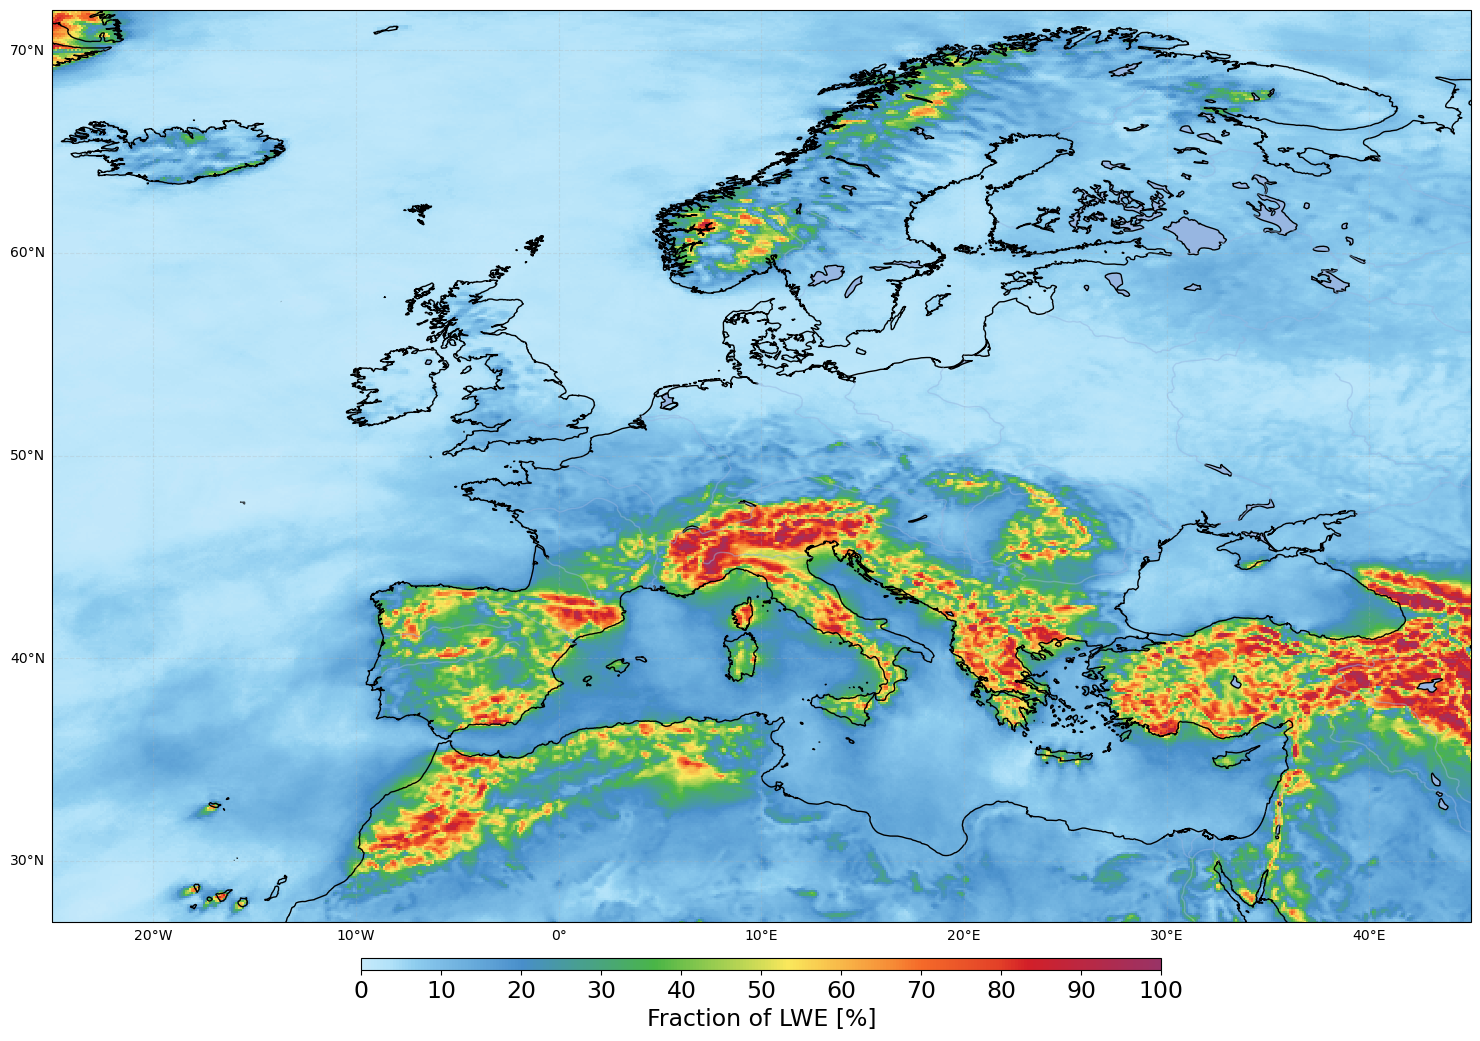

In [8]:
lwe_norm = (lwe / 2160) * 100

# Plotting the data
plot_map(
    lwe_norm,
    xmin=0,
    xmax=100,
    colormap=cmap,
    label="Fraction of LWE [%]",
    delta=20,
    region="eur",
    type="pcolormesh",
)

#### *High wind events*

In [9]:
# Importing the indicator
from energy_onshore import high_wind_events

# Running the indicator
hwe = high_wind_events(ws100, 20.0)
hwe

<xarray.DataArray 'hwe' (lat: 451, lon: 701)>
dask.array<sum-aggregate, shape=(451, 701), dtype=int64, chunksize=(451, 701), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 27.0 27.1 27.2 27.3 27.4 ... 71.6 71.7 71.8 71.9 72.0
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
Attributes:
    shortname:  hwe
    longname:   Number of high wind events
    units:      -

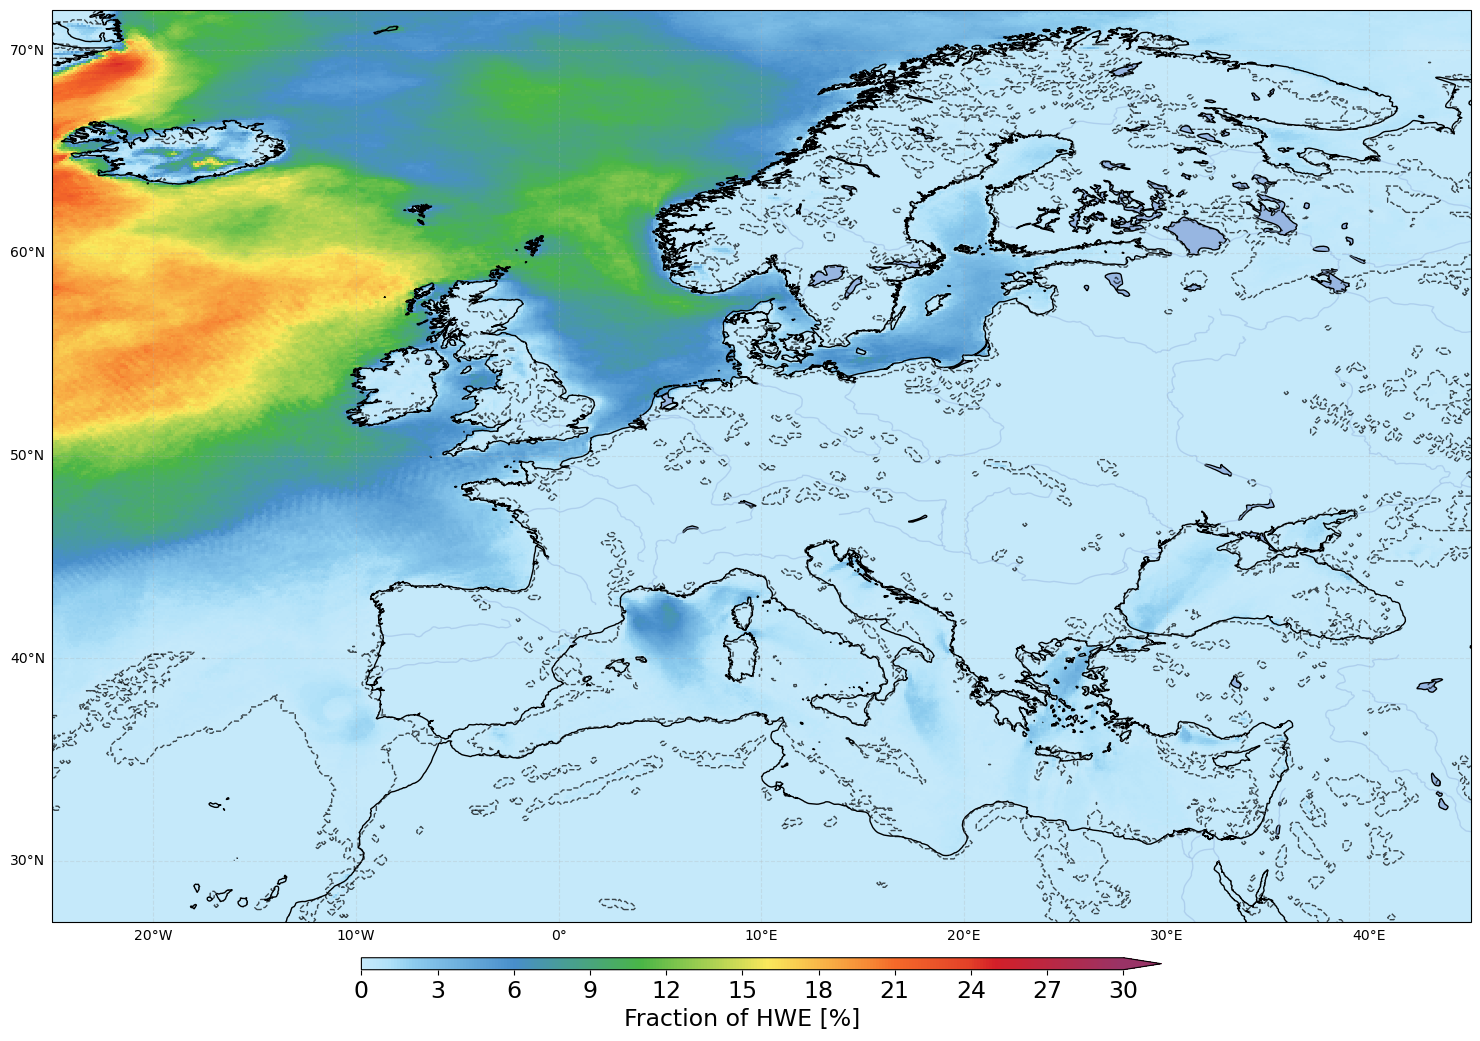

In [10]:
hwe_norm = (hwe / 2160) * 100

# Plotting the data
plot_map(
    hwe_norm,
    xmin=0,
    xmax=30,
    colormap=cmap,
    label="Fraction of HWE [%]",
    delta=20,
    region="eur",
    type="pcolormesh",
    extend="max",
)

#### *Capacity factor*

In [11]:
# Selecting the period of interest, for example: January 1991
var = 1
year = "1991"
months = ["01"]
t_sub = [year + m for m in months]
filenames = [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]

# Loading the wind data
ds_u100 = xr.open_mfdataset(filenames, concat_dim="time", combine="nested")
ds_u100.close()

var = 2
year = "1991"
months = ["01"]
t_sub = [year + m for m in months]
filenames = [
    path + variables[var] + "/" + variables[var] + "_" + t_sub[i] + "_eur.nc"
    for i in range(len(t_sub))
]

# Loading the wind data
ds_v100 = xr.open_mfdataset(filenames, concat_dim="time", combine="nested")
ds_v100.close()

ws100 = wind_speed(ds_u100["u"], ds_v100["v"])

In [12]:
# Importing the indicator
from energy_onshore import capacity_factor

# Running the indicator
cf_S = capacity_factor(ws100, iec_class="S")
cf_III = capacity_factor(ws100, iec_class="III")

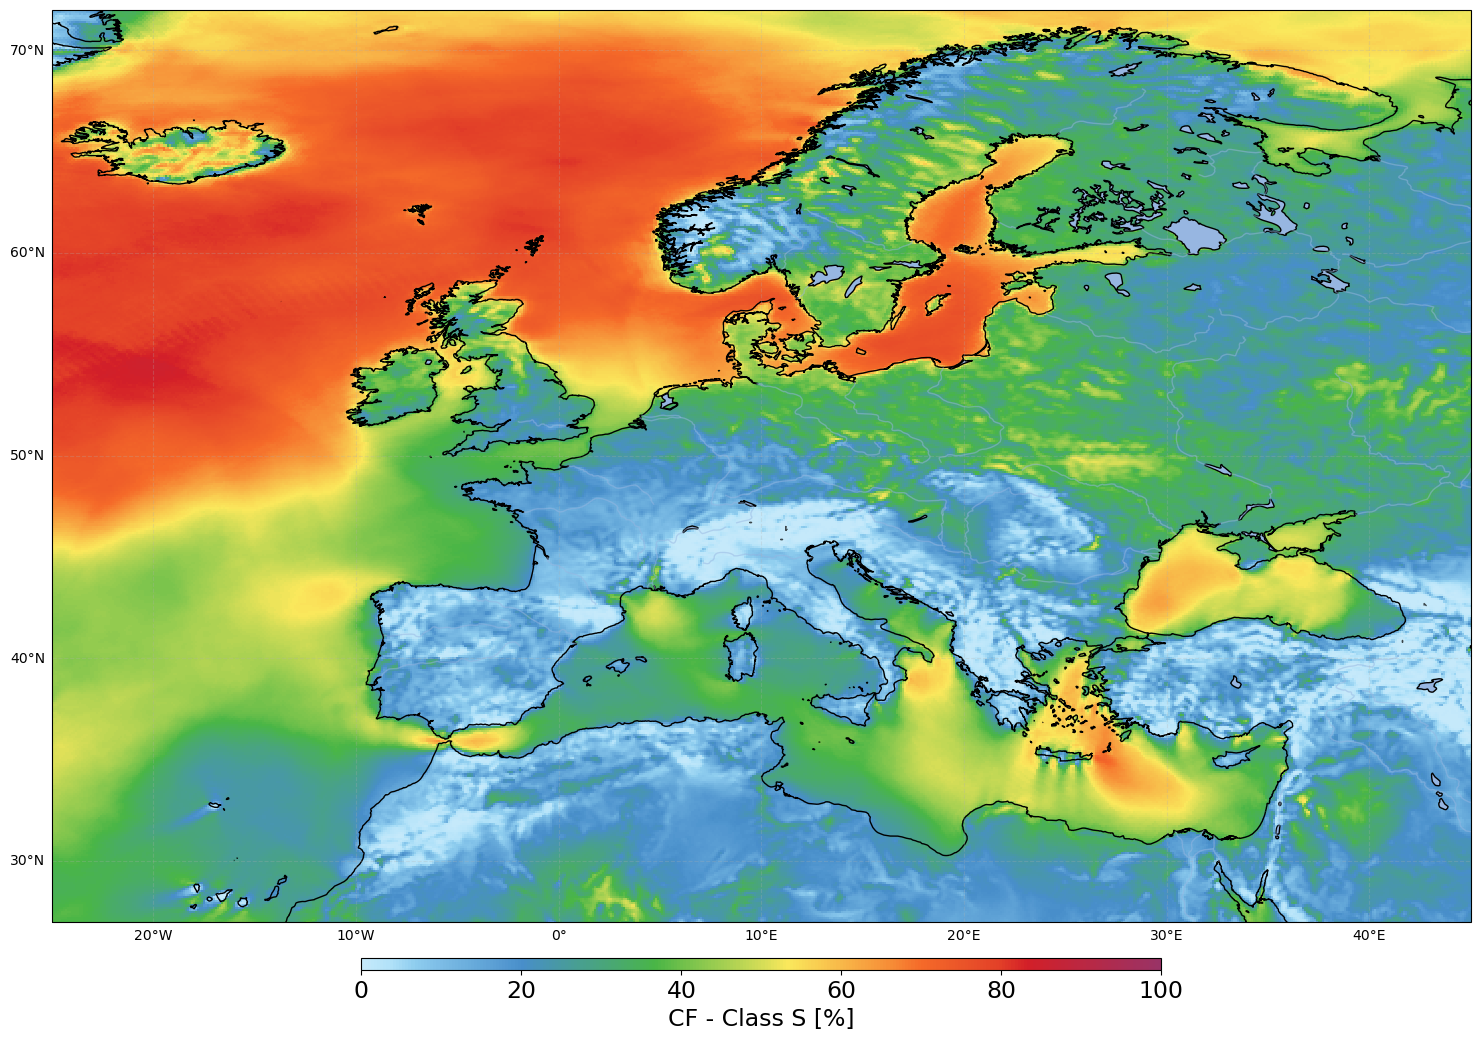

In [13]:
cf_mean = cf_S.mean(dim="time", skipna=False)

# Plotting the data
plot_map(
    cf_mean * 100,
    0,
    100,
    cmap,
    label="CF - Class S [%]",
    delta=10,
    region="eur",
    type="pcolormesh",
    extend="neither",
)

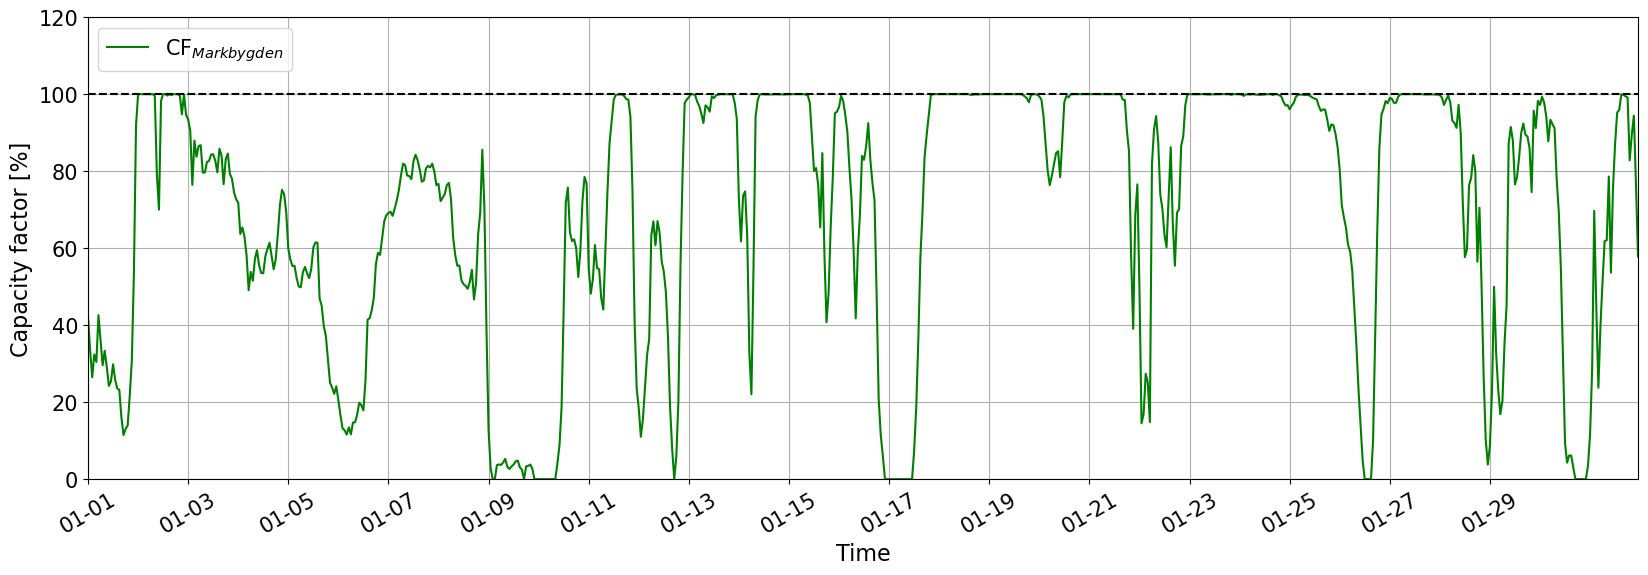

In [25]:
# We can show also show the data for a specific point as a time series:
lon = lon_mb
lat = lat_mb
cf_mb = select_point(cf_III, lon, lat)
ts = [cf_mb * 100]
labels = ["CF$_{Markbygden}$"]

# Plotting the time series
plot_time_series(
    ts,
    "Time",
    "Capacity factor [%]",
    labels,
    0,
    120,
    "1991-01",
    "1991-02",
    "green",
    hline=100.0,
)

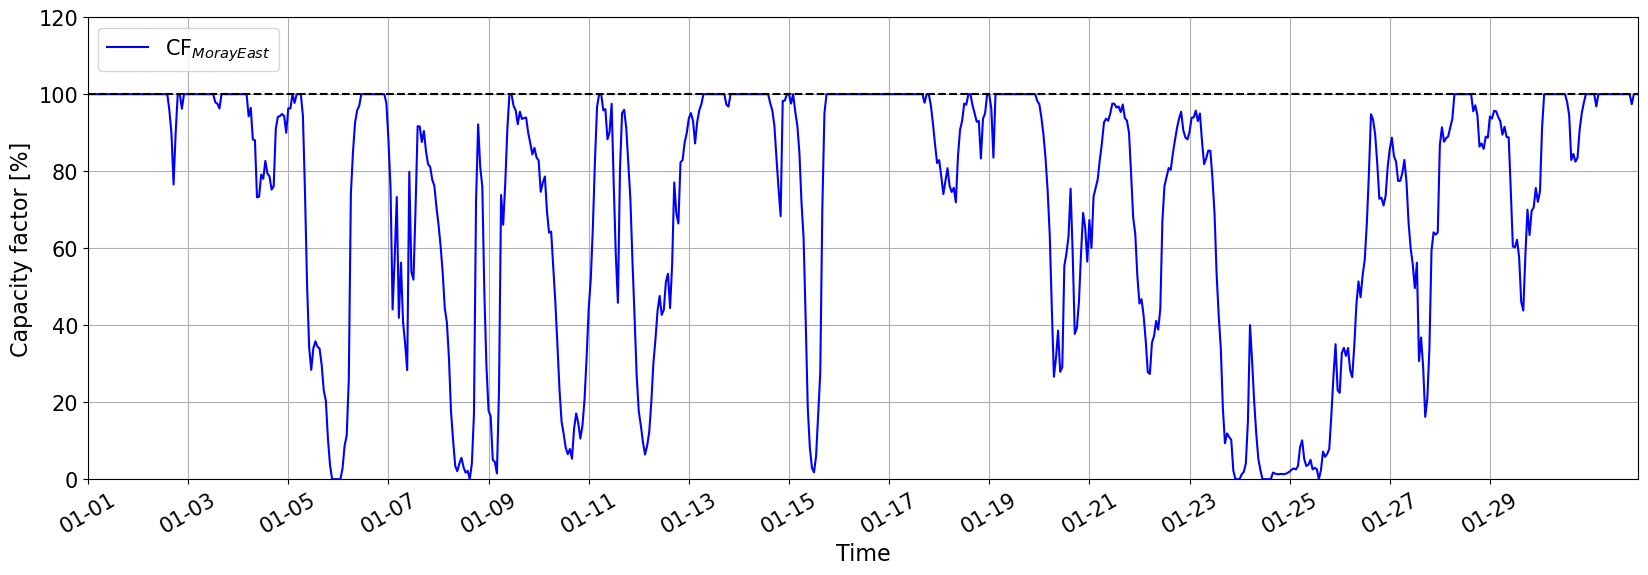

In [26]:
# We can show also show the data for a specific point as a time series:
lon = lon_me
lat = lat_me
cf_mb = select_point(cf_S, lon, lat)
ts = [cf_mb * 100]
labels = ["CF$_{Moray East}$"]

# Plotting the time series
plot_time_series(
    ts,
    "Time",
    "Capacity factor [%]",
    labels,
    0,
    120,
    "1991-01",
    "1991-02",
    "blue",
    hline=100.0,
)

#### *Wind speed and capacity factor histograms*

In [63]:
##Importing the indicator
from energy_onshore import wind_speed_histogram_1D

# Running the indicator
ws_me, be_me = wind_speed_histogram_1D(ws100, 30, lon_me, lat_me)
ws_mb, be_mb = wind_speed_histogram_1D(ws100, 30, lon_mb, lat_mb)

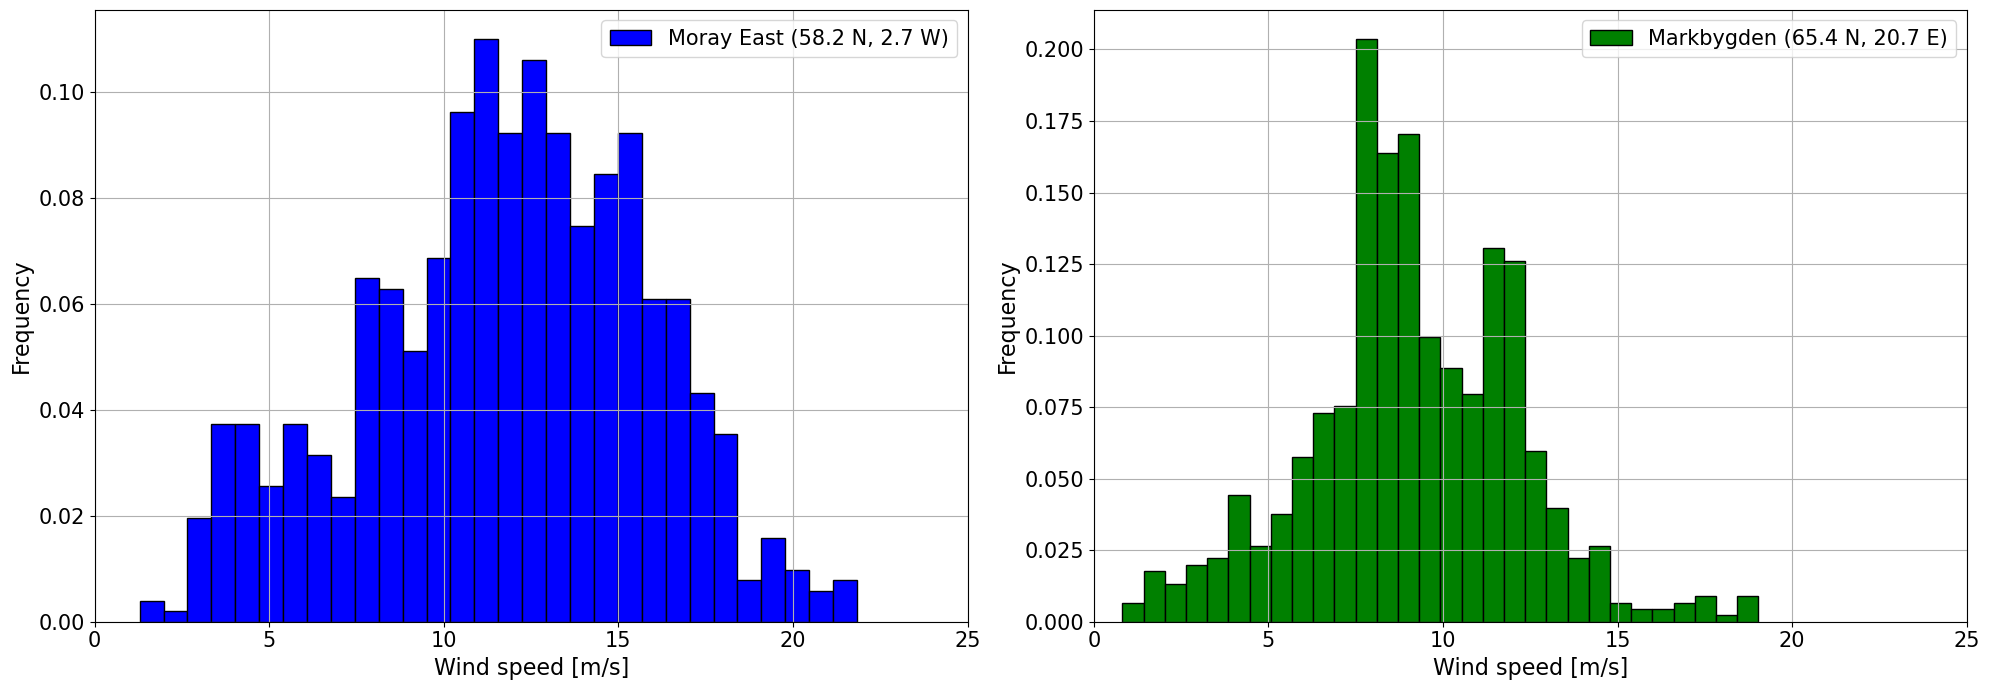

In [64]:
# Create a figure and a set of subplots with GridSpec
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Adjust width ratios as needed

# be_me = be_me - be_me[0]
# be_mb = be_mb - be_mb[0]

# First subplot for Moray East wind speed histogram
ax1 = plt.subplot(gs[0])
ax1.hist(
    be_me[:-1],
    bins=be_me,
    weights=ws_me,
    color="blue",
    edgecolor="black",
    label="Moray East (58.2 N, 2.7 W)",
    density=True,
)
ax1.set_xlabel("Wind speed [m/s]", fontsize=16)
ax1.set_ylabel("Frequency", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=15)
ax1.set_xlim(0, 25)
ax1.legend(fontsize=15)
ax1.grid(True)

# Second subplot for Markbygden wind speed histogram
ax2 = plt.subplot(gs[1])
ax2.hist(
    be_mb[:-1],
    bins=be_mb,
    weights=ws_mb,
    color="green",
    edgecolor="black",
    label="Markbygden (65.4 N, 20.7 E)",
    density=True,
)
ax2.set_xlabel("Wind speed [m/s]", fontsize=16)
ax2.set_ylabel("Frequency", fontsize=16)
ax2.tick_params(axis="both", which="major", labelsize=15)
ax2.set_xlim(0, 25)
ax2.legend(fontsize=15)
ax2.grid(True)

# Display the figure with both histograms
plt.tight_layout()
plt.show()

In [29]:
##Importing the indicator
from energy_onshore import capacity_factor_histogram_1D

# Running the indicator
cf_me, be_me = capacity_factor_histogram_1D(ws100, 30, lon_me, lat_me, iec_class="S")
cf_mb, be_mb = capacity_factor_histogram_1D(ws100, 30, lon_mb, lat_mb, iec_class="III")

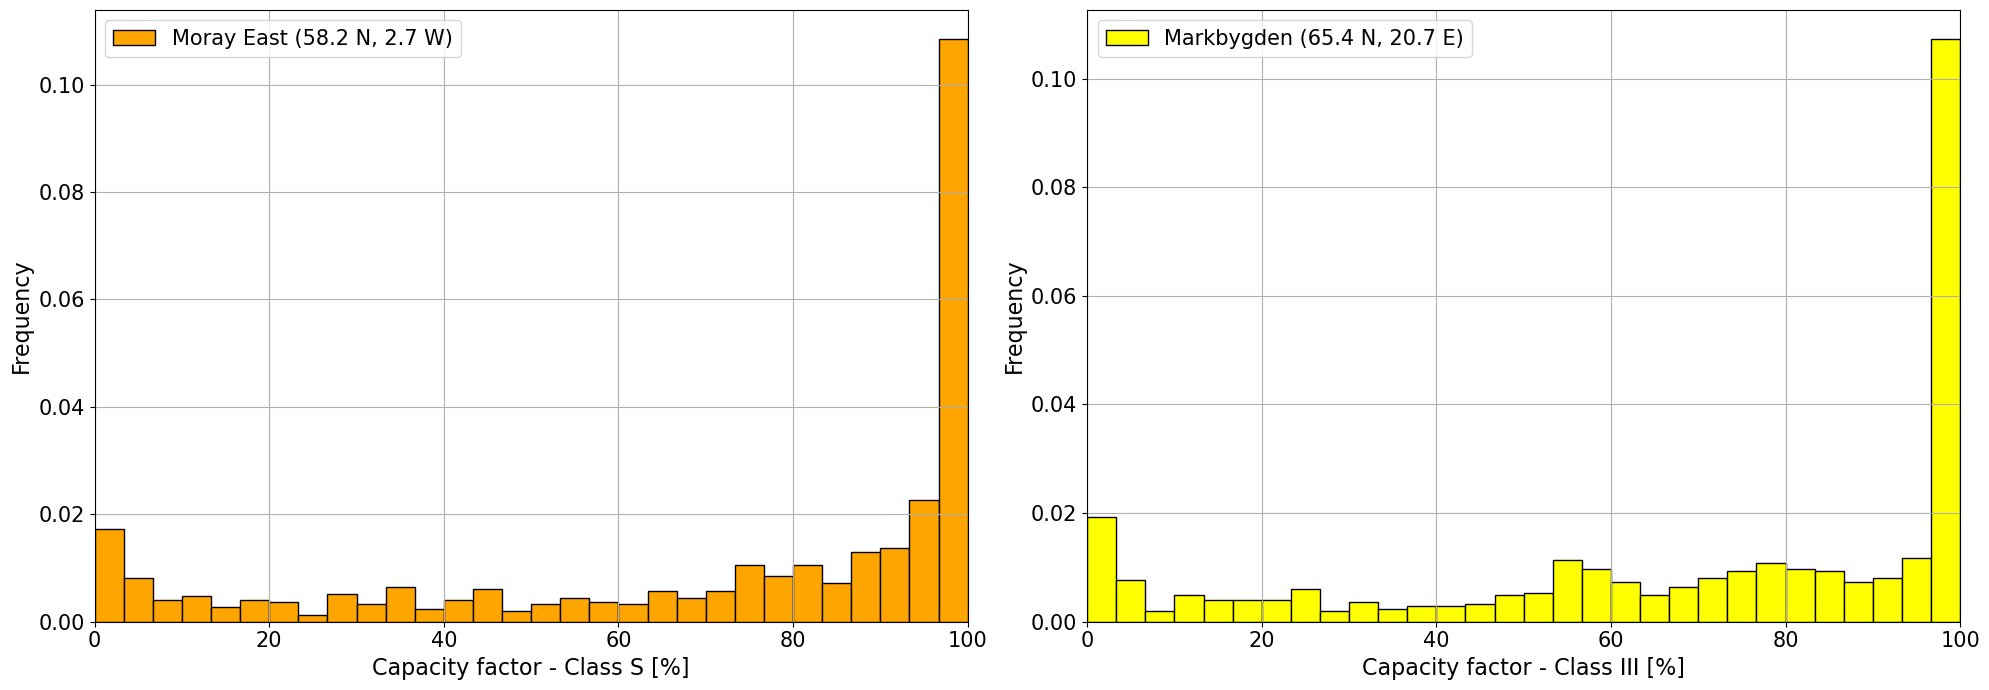

In [45]:
# Create a figure and a set of subplots with GridSpec
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Adjust width ratios as needed

# First subplot for Moray East CF histogram
ax1 = plt.subplot(gs[0])
ax1.hist(
    be_me[:-1] * 100,
    bins=be_me * 100,
    weights=cf_me,
    color="orange",
    edgecolor="black",
    label="Moray East (58.2 N, 2.7 W)",
    density=True,
)
ax1.set_xlabel("Capacity factor - Class S [%]", fontsize=16)
ax1.set_ylabel("Frequency", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=15)
ax1.set_xlim(0, 100)
ax1.legend(fontsize=15)
ax1.grid(True)

# Second subplot for Markbygden CF histogram
ax2 = plt.subplot(gs[1])
ax2.hist(
    be_mb[:-1] * 100,
    bins=be_mb * 100,
    weights=cf_mb,
    color="yellow",
    edgecolor="black",
    label="Markbygden (65.4 N, 20.7 E)",
    density=True,
)
ax2.set_xlabel("Capacity factor - Class III [%]", fontsize=16)
ax2.set_ylabel("Frequency", fontsize=16)
ax2.tick_params(axis="both", which="major", labelsize=15)
ax2.set_xlim(0, 100)
ax2.legend(fontsize=15)
ax2.grid(True)

# Display the figure with both histograms
plt.tight_layout()
plt.show()

#### *Annual Energy Production*

In [65]:
# Importing the indicator
from energy_onshore import annual_energy_production_wind

# Running the indicator
cf_me = select_point(cf_S, lon_me, lat_me)
cf_mb = select_point(cf_III, lon_mb, lat_mb)

aep_S = annual_energy_production_wind(cf_me, 9.5, num_turbines=1)
aep_III = annual_energy_production_wind(cf_mb, 3.6, num_turbines=1)

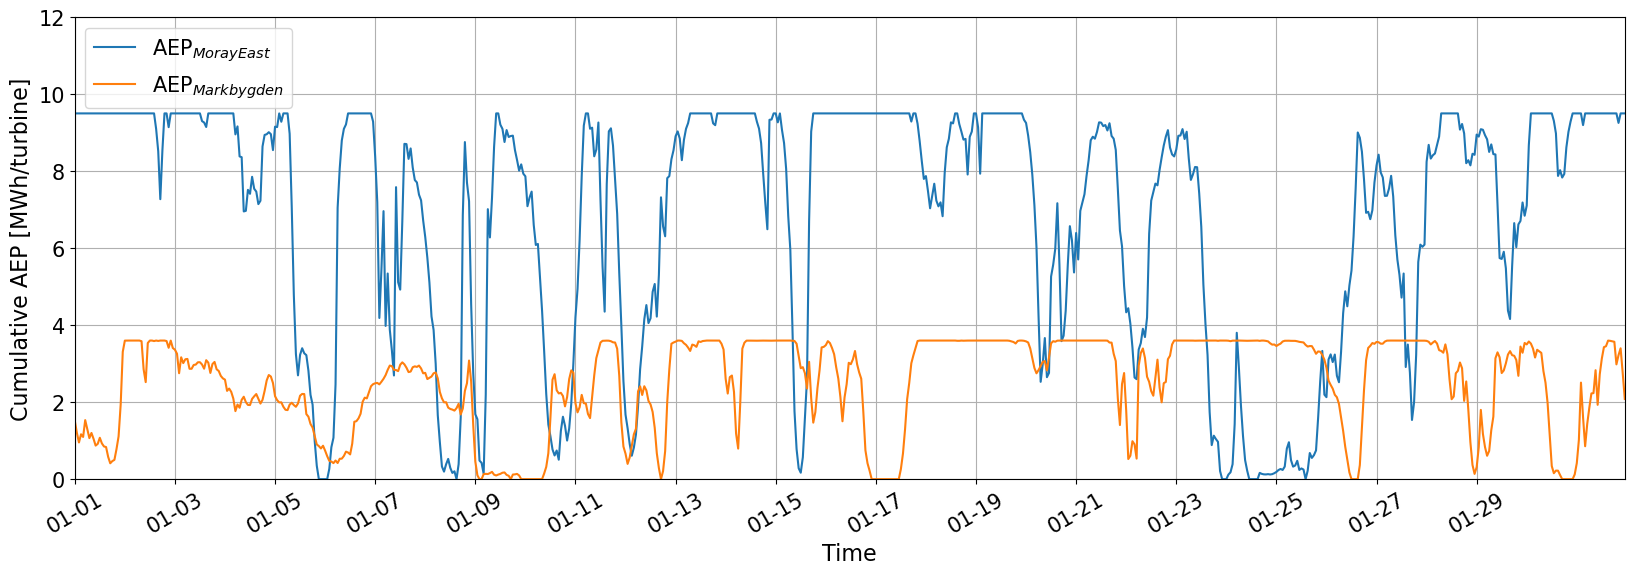

In [77]:
# We can show also show the data for a specific point as a time series:
lon = lon_me
lat = lat_me

ts = [aep_S, aep_III]
labels = ["AEP$_{Moray East}$", "AEP$_{Markbygden}$"]

# Plotting the time series
plot_time_series1(
    ts,
    "Time",
    "Cumulative AEP [MWh/turbine]",
    labels,
    0,
    12.0,
    "1991-01",
    "1991-02",
    hline=None,
)

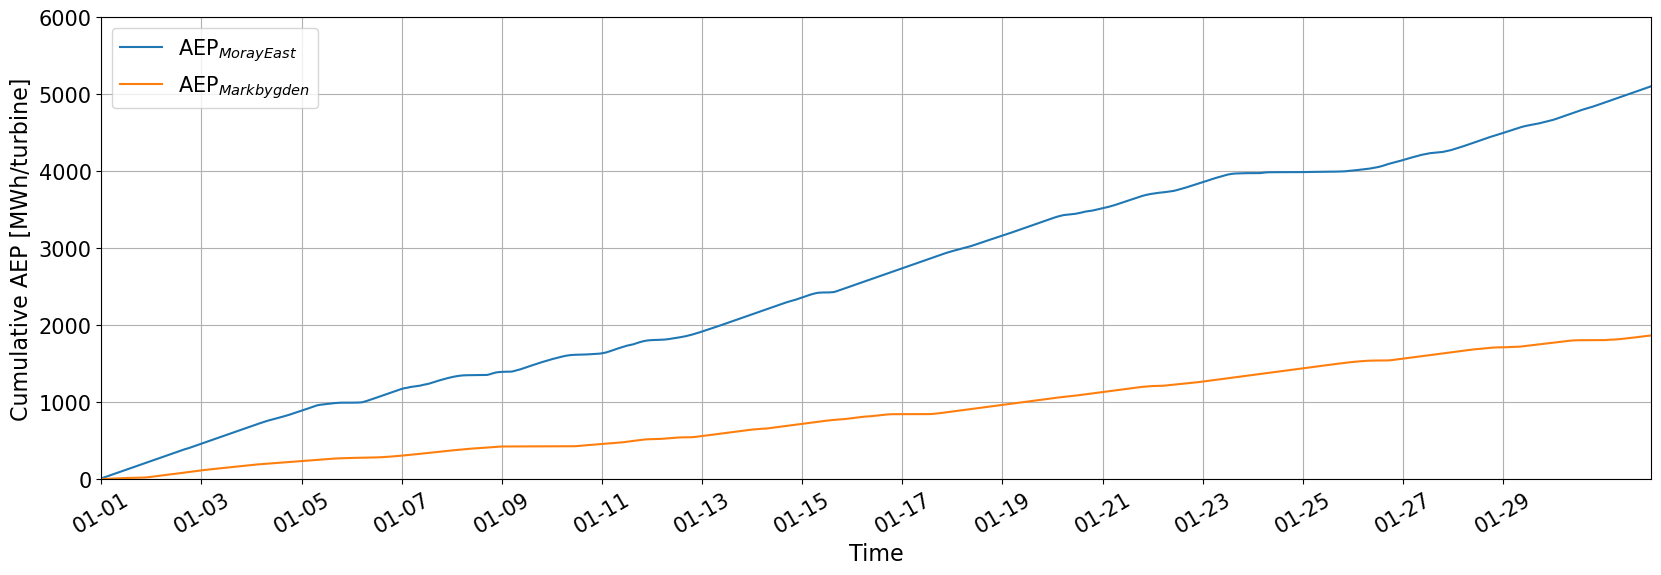

In [71]:
# We can show also show the data for a specific point as a time series:
lon = lon_me
lat = lat_me

aep_cumulative1 = np.cumsum(aep_S)
aep_cumulative2 = np.cumsum(aep_III)

ts = [aep_cumulative1, aep_cumulative2]
labels = ["AEP$_{Moray East}$", "AEP$_{Markbygden}$"]

# Plotting the time series
plot_time_series1(
    ts,
    "Time",
    "Cumulative AEP [MWh/turbine]",
    labels,
    0,
    6000,
    "1991-01",
    "1991-02",
    hline=None,
)